# This Python Notebook is used to test out and develop a Spectrogram Browser GUI

In [6]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import os

In [7]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import os

class WavtoSpec:
    def __init__(self, file_path, dst_dir):
        self.file_path = file_path
        self.dst_dir = dst_dir

    def convert_to_spectrogram_and_save(self, save_files='n'):
        try:
            # Read the WAV file
            samplerate, data = wavfile.read(self.file_path)

            # High-pass filter (adjust the filtering frequency as necessary)
            b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
            data = filtfilt(b, a, data)

            # Canary song analysis parameters
            NFFT = 2048  # Number of points in FFT
            step_size = 119  # Step size for overlap

            # Calculate the overlap in samples
            overlap_samples = NFFT - step_size

            # Use a Gaussian window
            window = windows.gaussian(NFFT, std=NFFT/8)

            # Compute the spectrogram with the Gaussian window
            f, t, Sxx = spectrogram(data, fs=samplerate, window=window, nperseg=NFFT, noverlap=overlap_samples)

            # Convert to dB
            Sxx_log = 10 * np.log10(Sxx)

            # Clipping and Normalization
            clipping_level = -2  # dB
            Sxx_log_clipped = np.clip(Sxx_log, a_min=clipping_level, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            # Visualization
            plt.figure(figsize=(10, 4))
            plt.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[t.min(), t.max(), f.min(), f.max()], cmap='jet')
            plt.title('Spectrogram')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.colorbar(format='%+2.0f dB')
            plt.show()

            if save_files.lower() == 'y':
                # Define the path where the spectrogram will be saved
                spec_filename = os.path.splitext(os.path.basename(self.file_path))[0]
                spec_file_path = os.path.join(self.dst_dir, spec_filename + '.npz')

                # Saving the spectrogram and the labels
                labels = np.full((Sxx_log_normalized.shape[1],), 0)  # Adjust the label array as needed
                np.savez_compressed(spec_file_path, s=Sxx_log_normalized, labels=labels)

                # Print out the path to the saved file
                print(f"Spectrogram saved to {spec_file_path}")

        except ValueError as e:
            print(f"Error reading {self.file_path}: {e}")


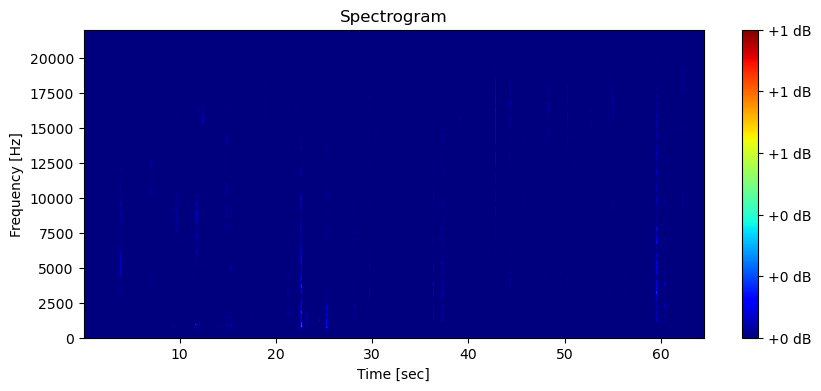

In [8]:
# Assuming the code for WavtoSpec class has been defined as provided above.

# Define the path to the input WAV file and the destination directory for output
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5483_sample_songs/216_sample/USA5483_45749.26330466_4_2_7_18_50.wav'
destination_directory = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_outputs'

# Create an instance of the WavtoSpec class with the specified file path and destination directory
wav_to_spec_processor = WavtoSpec(file_path, destination_directory)

# Process the file and choose whether to save it or not
wav_to_spec_processor.convert_to_spectrogram_and_save(save_files='n')  # Pass 'y' to save, 'n' to not save



## Now, have it split up the spectrograms into 1-minute panels and plot them in a subplot

In [9]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import os


import tkinter as tk

def get_screen_resolution():
    # Create a root window
    root = tk.Tk()
    
    # Hide the root window (optional)
    root.withdraw()

    # Get the width and height of the screen
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    # Destroy the root window
    root.destroy()

    return screen_width, screen_height

# Usage
width, height = get_screen_resolution()
print(f"The screen resolution is: {width}x{height}")


class WavtoSpec:
    def __init__(self, file_path):
        self.file_path = file_path

    def plot_spectrograms_by_segment(self, segment_duration=10):
        try:
            # Read the WAV file
            samplerate, data = wavfile.read(self.file_path)

            # Calculate the length of the audio in seconds
            duration_seconds = data.shape[0] / samplerate

            # High-pass filter (adjust the filtering frequency as necessary)
            b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
            data = filtfilt(b, a, data)

            # Set parameters for the spectrogram
            NFFT = 2048  # Number of points in FFT
            step_size = 119  # Step size for overlap
            window = windows.gaussian(NFFT, std=NFFT/8)

            # Determine the number of segments and the length in samples
            segment_length_samples = segment_duration * samplerate  # segment_duration seconds worth of samples
            num_segments = int(np.ceil(duration_seconds / segment_duration))

            # Create a figure for the subplots
            fig, axs = plt.subplots(num_segments, 1, figsize=(10, 2 * num_segments), sharex=True)

            for i in range(num_segments):
                start_sample = i * segment_length_samples
                end_sample = start_sample + segment_length_samples

                # Check if the end sample exceeds the length of the data
                if end_sample > data.shape[0]:
                    # Pad the segment data with zeros if it's shorter than the required segment length
                    segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                    segment_data[:data.shape[0] - start_sample] = data[start_sample:]
                else:
                    segment_data = data[start_sample:end_sample]

                # Compute the spectrogram for the segment
                f, t, Sxx = spectrogram(segment_data, fs=samplerate, window=window, nperseg=NFFT, noverlap=(NFFT - step_size))
                Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)  # Avoid log of zero

                # Normalize and clip the spectrogram
                clipping_level = -2  # dB
                Sxx_log_clipped = np.clip(Sxx_log, a_min=clipping_level, a_max=None)
                Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

                # Plot the spectrogram
                ax = axs[i] if num_segments > 1 else axs
                ax.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[0, segment_duration, f.min(), f.max()], cmap='jet')
                ax.set_ylabel('')  # Remove y-axis label
                ax.set_yticks([])  # Ensure no ticks are displayed on the y-axis
                if i == num_segments - 1:
                    ax.set_xlabel('Time [sec]')

            plt.tight_layout()
            plt.show()

        except ValueError as e:
            print(f"Error reading {self.file_path}: {e}")


The screen resolution is: 1512x982


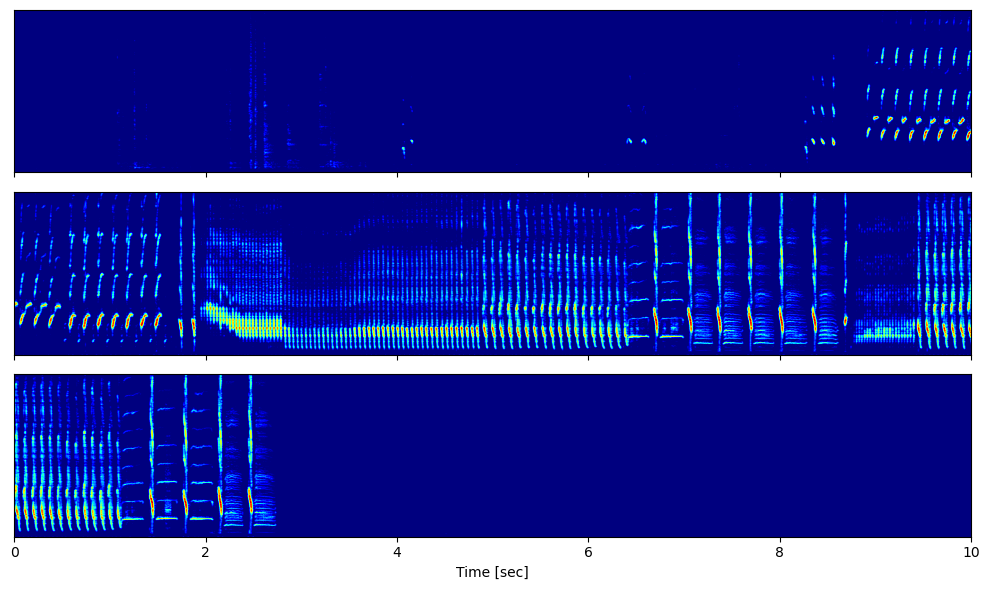

In [10]:
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
wav_processor = WavtoSpec(file_path)
wav_processor.plot_spectrograms_by_segment(segment_duration=10)  # Default is set to 10 seconds



In [11]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import os
import tkinter as tk

def get_screen_resolution():
    # Create a root window
    root = tk.Tk()
    
    # Hide the root window (optional)
    root.withdraw()

    # Get the width and height of the screen in pixels
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    # Convert pixels to inches for matplotlib (assuming 100 dpi)
    screen_width_inches = screen_width / 100
    screen_height_inches = screen_height / 100

    # Destroy the root window
    root.destroy()

    return screen_width_inches, screen_height_inches

# Get screen resolution in inches
width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

class WavtoSpec:
    def __init__(self, file_path):
        self.file_path = file_path

    def plot_spectrograms_by_segment(self, segment_duration=10):
        try:
            # Read the WAV file
            samplerate, data = wavfile.read(self.file_path)

            # Calculate the length of the audio in seconds
            duration_seconds = data.shape[0] / samplerate

            # High-pass filter (adjust the filtering frequency as necessary)
            b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
            data = filtfilt(b, a, data)

            # Set parameters for the spectrogram
            NFFT = 2048  # Number of points in FFT
            step_size = 119  # Step size for overlap
            window = windows.gaussian(NFFT, std=NFFT/8)

            # Determine the number of segments and the length in samples
            segment_length_samples = segment_duration * samplerate  # segment_duration seconds worth of samples
            num_segments = int(np.ceil(duration_seconds / segment_duration))

            # Create a figure for the subplots, adjusting to screen size
            fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True)

            for i in range(num_segments):
                start_sample = i * segment_length_samples
                end_sample = start_sample + segment_length_samples

                # Check if the end sample exceeds the length of the data
                if end_sample > data.shape[0]:
                    # Pad the segment data with zeros if it's shorter than the required segment length
                    segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                    segment_data[:data.shape[0] - start_sample] = data[start_sample:]
                else:
                    segment_data = data[start_sample:end_sample]

                # Compute the spectrogram for the segment
                f, t, Sxx = spectrogram(segment_data, fs=samplerate, window=window, nperseg=NFFT, noverlap=(NFFT - step_size))
                Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)  # Avoid log of zero

                # Normalize and clip the spectrogram
                clipping_level = -2  # dB
                Sxx_log_clipped = np.clip(Sxx_log, a_min=clipping_level, a_max=None)
                Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

                # Plot the spectrogram
                ax = axs[i] if num_segments > 1 else axs
                ax.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[0, segment_duration, f.min(), f.max()], cmap='jet')
                ax.set_ylabel('')  # Remove y-axis label
                ax.set_yticks([])  # Ensure no ticks are displayed on the y-axis
                if i == num_segments - 1:
                    ax.set_xlabel('Time [sec]')

            plt.tight_layout()
            plt.show()

        except ValueError as e:
            print(f"Error reading {self.file_path}: {e}")


The screen resolution in inches is: 15.12x9.82


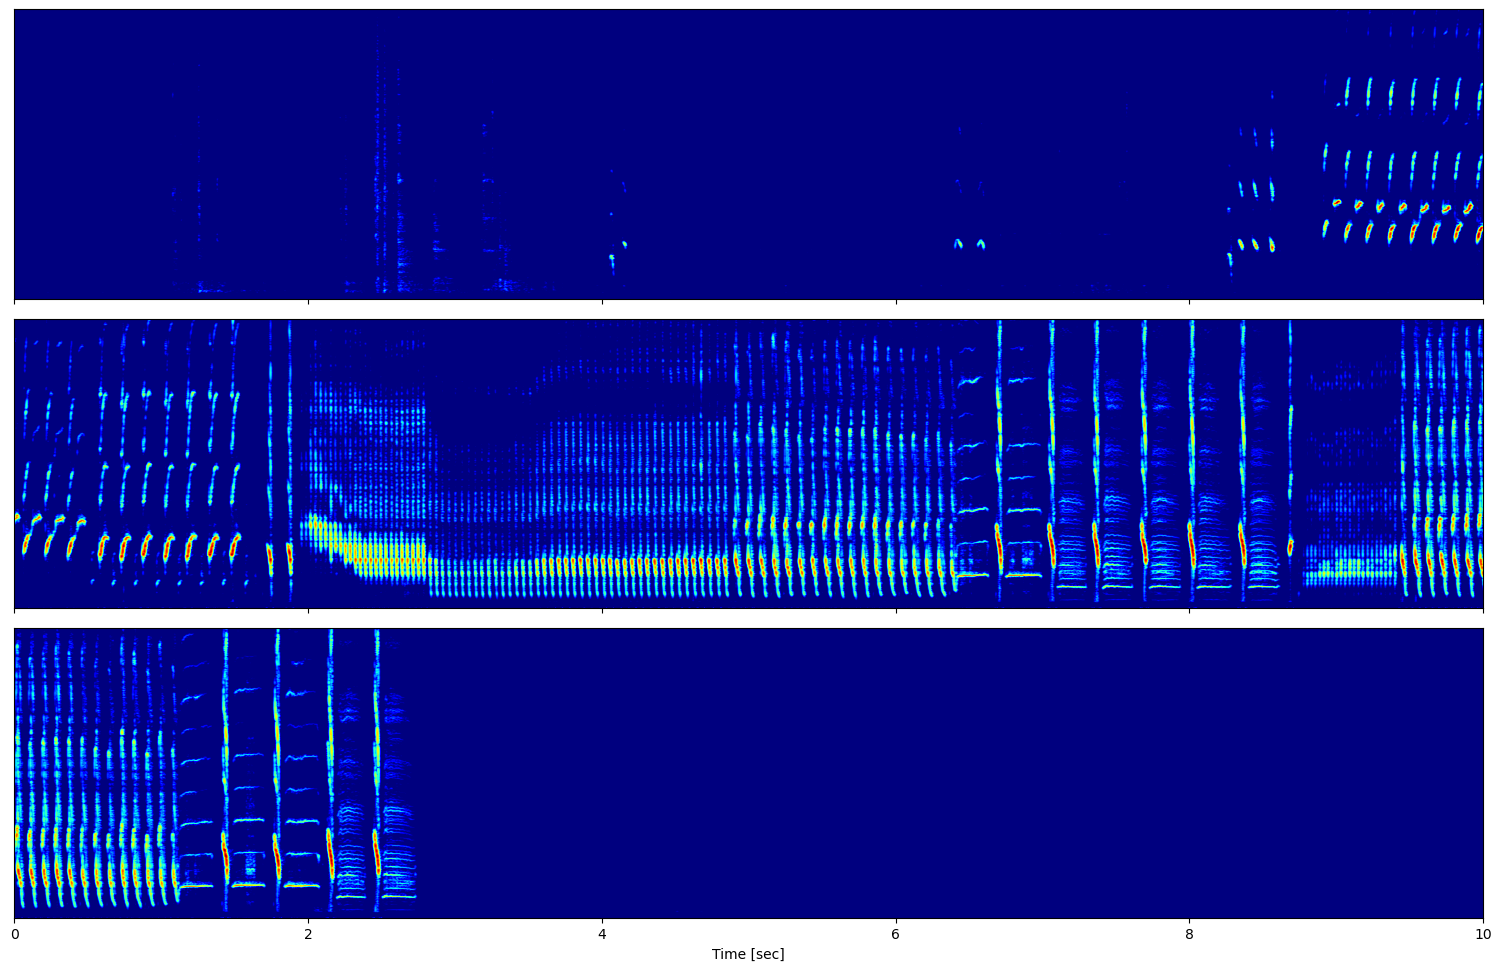

In [12]:
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
wav_processor = WavtoSpec(file_path)
wav_processor.plot_spectrograms_by_segment(segment_duration=10)  # Default is set to 10 seconds


In [13]:
class WavtoSpec:
    def __init__(self, file_path, folder_path='.', save_image_as_png='n'):
        self.file_path = file_path
        self.folder_path = folder_path
        self.save_image_as_png = save_image_as_png

    def plot_spectrograms_by_segment(self, segment_duration=10):
        try:
            # Read the WAV file
            samplerate, data = wavfile.read(self.file_path)

            # Calculate the length of the audio in seconds
            duration_seconds = data.shape[0] / samplerate

            # High-pass filter (adjust the filtering frequency as necessary)
            b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
            data = filtfilt(b, a, data)

            # Set parameters for the spectrogram
            NFFT = 2048  # Number of points in FFT
            step_size = 119  # Step size for overlap
            window = windows.gaussian(NFFT, std=NFFT/8)

            # Determine the number of segments and the length in samples
            segment_length_samples = segment_duration * samplerate  # segment_duration seconds worth of samples
            num_segments = int(np.ceil(duration_seconds / segment_duration))

            # Create a figure for the subplots, adjusting to screen size
            fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True)

            for i in range(num_segments):
                start_sample = i * segment_length_samples
                end_sample = start_sample + segment_length_samples

                if end_sample > data.shape[0]:
                    # Pad the segment data with zeros if it's shorter than the required segment length
                    segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                    segment_data[:data.shape[0] - start_sample] = data[start_sample:]
                else:
                    segment_data = data[start_sample:end_sample]

                # Compute the spectrogram for the segment
                f, t, Sxx = spectrogram(segment_data, fs=samplerate, window=window, nperseg=NFFT, noverlap=(NFFT - step_size))
                Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)  # Avoid log of zero
                # Normalize and clip the spectrogram
                clipping_level = -2  # dB
                Sxx_log_clipped = np.clip(Sxx_log, a_min=clipping_level, a_max=None)
                Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

                # Adjust frequency limit to bottom 1/4
                quarter_freq = f[int(len(f) / 4)]

                # Plot the spectrogram with adjusted y-axis limits
                ax = axs[i] if num_segments > 1 else axs
                ax.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[0, segment_duration, 0, quarter_freq], cmap='binary')
                ax.set_ylabel('')  # Remove y-axis label
                ax.set_yticks([])  # Ensure no ticks are displayed on the y-axis
                if i == num_segments - 1:
                    ax.set_xlabel('Time [sec]')

            plt.tight_layout()
            
            if self.save_image_as_png == 'y':
                if not os.path.exists(self.folder_path):
                    os.makedirs(self.folder_path)
                base_name = os.path.splitext(os.path.basename(self.file_path))[0]
                file_name = os.path.join(self.folder_path, f"{base_name}_spectrogram.png")
                plt.savefig(file_name)
                print(f"Spectrogram saved to {file_name}")

            plt.show()

        except ValueError as e:
            print(f"Error reading {self.file_path}: {e}")


Spectrogram saved to /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_outputs/USA5288_45390.29509926_4_8_8_11_49_spectrogram.png


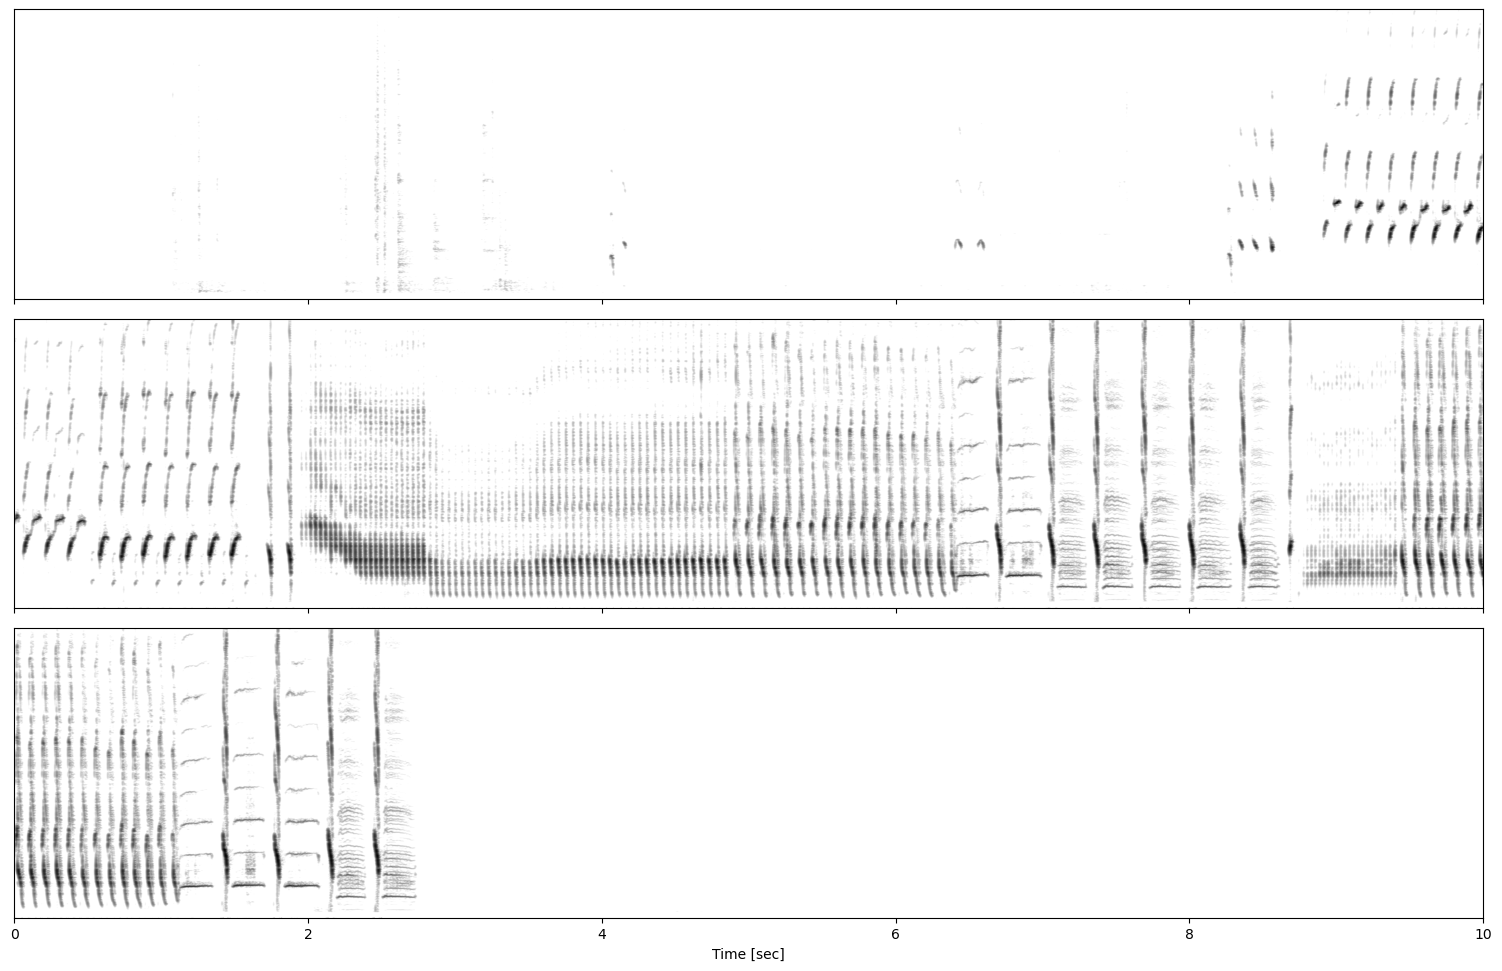

In [14]:
# Example usage
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_outputs'
save_image_as_png = 'y'  # Set to 'y' to save the image
spectrogram_plotter = WavtoSpec(file_path, folder_path, save_image_as_png)
spectrogram_plotter.plot_spectrograms_by_segment()

# Now, iterate over every .wav file inside a directory

In [15]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import os
import tkinter as tk

def get_screen_resolution():
    # Create a root window
    root = tk.Tk()
    
    # Hide the root window (optional)
    root.withdraw()

    # Get the width and height of the screen in pixels
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    # Convert pixels to inches for matplotlib (assuming 100 dpi)
    screen_width_inches = screen_width / 100
    screen_height_inches = screen_height / 100

    # Destroy the root window
    root.destroy()

    return screen_width_inches, screen_height_inches

# Get screen resolution in inches
width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

class WavtoSpec:
    def __init__(self, input_folder, output_folder):
        self.input_folder = input_folder
        self.output_folder = output_folder
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)

    def process_files(self):
        # Scan through the input folder for WAV files
        for file_name in os.listdir(self.input_folder):
            if file_name.endswith('.wav'):
                file_path = os.path.join(self.input_folder, file_name)
                print(f"Processing {file_path}")
                self.plot_spectrograms_by_segment(file_path)

    def plot_spectrograms_by_segment(self, file_path, segment_duration=10):
        try:
            # Read the WAV file
            samplerate, data = wavfile.read(file_path)

            # Calculate the length of the audio in seconds
            duration_seconds = data.shape[0] / samplerate

            # High-pass filter (adjust the filtering frequency as necessary)
            b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
            data = filtfilt(b, a, data)

            # Set parameters for the spectrogram
            NFFT = 2048  # Number of points in FFT
            step_size = 119  # Step size for overlap
            window = windows.gaussian(NFFT, std=NFFT/8)

            # Determine the number of segments and the length in samples
            segment_length_samples = segment_duration * samplerate  # segment_duration seconds worth of samples
            num_segments = int(np.ceil(duration_seconds / segment_duration))

            # Create a figure for the subplots, adjusting to screen size
            fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True)

            for i in range(num_segments):
                start_sample = i * segment_length_samples
                end_sample = start_sample + segment_length_samples

                # Check if the end sample exceeds the length of the data
                if end_sample > data.shape[0]:
                    # Pad the segment data with zeros if it's shorter than the required segment length
                    segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                    segment_data[:data.shape[0] - start_sample] = data[start_sample:]
                else:
                    segment_data = data[start_sample:end_sample]

                # Compute the spectrogram for the segment
                f, t, Sxx = spectrogram(segment_data, fs=samplerate, window=window, nperseg=NFFT, noverlap=(NFFT - step_size))
                Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)  # Avoid log of zero

                # Normalize and clip the spectrogram
                clipping_level = -2  # dB
                Sxx_log_clipped = np.clip(Sxx_log, a_min=clipping_level, a_max=None)
                Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

                # Plot the spectrogram
                ax = axs[i] if num_segments > 1 else axs
                ax.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
                ax.set_ylabel('')
                ax.set_yticks([])
                if i == num_segments - 1:
                    ax.set_xlabel('Time [sec]')

            plt.tight_layout()
            
            # Save the plot as a PNG file
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            output_file_name = os.path.join(self.output_folder, f"{base_name}_spectrogram.png")
            plt.savefig(output_file_name)
            print(f"Spectrogram saved to {output_file_name}")

            plt.close(fig)  # Close the figure to free up memory

        except ValueError as e:
            print(f"Error reading {file_path}: {e}")


The screen resolution in inches is: 15.12x9.82


## Adjust to include the file name on the right side of the figure

In [16]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import os
import tkinter as tk

def get_screen_resolution():
    # Create a root window
    root = tk.Tk()
    
    # Hide the root window (optional)
    root.withdraw()

    # Get the width and height of the screen in pixels
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    # Convert pixels to inches for matplotlib (assuming 100 dpi)
    screen_width_inches = screen_width / 100
    screen_height_inches = screen_height / 100

    # Destroy the root window
    root.destroy()

    return screen_width_inches, screen_height_inches

# Get screen resolution in inches
width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

class WavtoSpec:
    def __init__(self, input_folder, output_folder):
        self.input_folder = input_folder
        self.output_folder = output_folder
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)

    def process_files(self):
        # Scan through the input folder for WAV files
        for file_name in os.listdir(self.input_folder):
            if file_name.endswith('.wav'):
                file_path = os.path.join(self.input_folder, file_name)
                print(f"Processing {file_path}")
                self.plot_spectrograms_by_segment(file_path)

    def plot_spectrograms_by_segment(self, file_path, segment_duration=10):
        try:
            # Read the WAV file
            samplerate, data = wavfile.read(file_path)

            # High-pass filter (adjust the filtering frequency as necessary)
            b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
            data = filtfilt(b, a, data)

            # Calculate the length of the audio in seconds
            duration_seconds = data.shape[0] / samplerate

            # Set parameters for the spectrogram
            NFFT = 2048  # Number of points in FFT
            step_size = 119  # Step size for overlap
            window = windows.gaussian(NFFT, std=NFFT/8)

            # Determine the number of segments and the length in samples
            segment_length_samples = segment_duration * samplerate  # segment_duration seconds worth of samples
            num_segments = int(np.ceil(duration_seconds / segment_duration))

            # Create a figure for the subplots, adjusting to screen size
            fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True)

            for i in range(num_segments):
                start_sample = i * segment_length_samples
                end_sample = start_sample + segment_length_samples

                # Check if the end sample exceeds the length of the data
                if end_sample > data.shape[0]:
                    segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                    segment_data[:data.shape[0] - start_sample] = data[start_sample:]
                else:
                    segment_data = data[start_sample:end_sample]

                # Compute the spectrogram
                f, t, Sxx = spectrogram(segment_data, fs=samplerate, window=window, nperseg=NFFT, noverlap=(NFFT - step_size))
                Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
                
                # Normalize and clip the spectrogram
                clipping_level = -2  # dB
                Sxx_log_clipped = np.clip(Sxx_log, a_min=clipping_level, a_max=None)
                Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

                # Plot the spectrogram
                ax = axs[i] if num_segments > 1 else axs
                ax.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
                ax.set_ylabel('')
                ax.set_yticks([])
                if i == num_segments - 1:
                    ax.set_xlabel('Time [sec]')

            # Add the filename as text to the right of the bottom panel
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            axs[-1].text(0.95, 0.05, f'File: {base_name}', horizontalalignment='right', verticalalignment='bottom', transform=axs[-1].transAxes, fontsize=10, color='black')

            plt.tight_layout()

            # Save the plot as a PNG file
            output_file_name = os.path.join(self.output_folder, f"{base_name}_spectrogram.png")
            plt.savefig(output_file_name)
            print(f"Spectrogram saved to {output_file_name}")

            plt.close(fig)  # Close the figure to free up memory

        except ValueError as e:
            print(f"Error reading {file_path}: {e}")

# if __name__ == "__main__":
#     # Example usage:
#     input_folder = 'path_to_your_input_folder'
#     output_folder = 'path_to_your_output_folder'
#     processor = WavtoSpec(input_folder, output_folder)
#     processor.process_files()import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import os
import tkinter as tk

def get_screen_resolution():
    # Create a root window
    root = tk.Tk()
    
    # Hide the root window (optional)
    root.withdraw()

    # Get the width and height of the screen in pixels
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    # Convert pixels to inches for matplotlib (assuming 100 dpi)
    screen_width_inches = screen_width / 100
    screen_height_inches = screen_height / 100

    # Destroy the root window
    root.destroy()

    return screen_width_inches, screen_height_inches

# Get screen resolution in inches
width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

class WavtoSpec:
    def __init__(self, input_folder, output_folder):
        self.input_folder = input_folder
        self.output_folder = output_folder
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)

    def process_files(self):
        # Scan through the input folder for WAV files
        for file_name in os.listdir(self.input_folder):
            if file_name.endswith('.wav'):
                file_path = os.path.join(self.input_folder, file_name)
                print(f"Processing {file_path}")
                self.plot_spectrograms_by_segment(file_path)

    def plot_spectrograms_by_segment(self, file_path, segment_duration=10):
        try:
            # Read the WAV file
            samplerate, data = wavfile.read(file_path)
            if data.ndim > 1:  # Handle stereo files
                data = data.mean(axis=1)

            # High-pass filter (adjust the filtering frequency as necessary)
            b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
            data = filtfilt(b, a, data)

            # Calculate the length of the audio in seconds
            duration_seconds = data.shape[0] / samplerate

            # Set parameters for the spectrogram
            NFFT = 2048  # Number of points in FFT
            step_size = 119  # Step size for overlap
            window = windows.gaussian(NFFT, std=NFFT/8)

            # Determine the number of segments and the length in samples
            segment_length_samples = segment_duration * samplerate  # segment_duration seconds worth of samples
            num_segments = int(np.ceil(duration_seconds / segment_duration))

            # Create a figure for the subplots, adjusting to screen size
            fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True)

            # Handle single subplot differently to avoid indexing issues
            if num_segments == 1:
                axs = [axs]

            for i in range(num_segments):
                start_sample = i * segment_length_samples
                end_sample = start_sample + segment_length_samples

                # Check if the end sample exceeds the length of the data
                if end_sample > data.shape[0]:
                    segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                    segment_data[:data.shape[0] - start_sample] = data[start_sample:]
                else:
                    segment_data = data[start_sample:end_sample]

                # Compute the spectrogram
                f, t, Sxx = spectrogram(segment_data, fs=samplerate, window=window, nperseg=NFFT, noverlap=(NFFT - step_size))
                Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
                
                # Normalize and clip the spectrogram
                clipping_level = -2  # dB
                Sxx_log_clipped = np.clip(Sxx_log, a_min=clipping_level, a_max=None)
                Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

                # Plot the spectrogram
                ax = axs[i]
                ax.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
                ax.set_ylabel('')
                ax.set_yticks([])
                if i == num_segments - 1:
                    ax.set_xlabel('Time [sec]')

            # Add the filename as text to the right of the bottom panel
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            axs[-1].text(0.95, 0.05, f'File: {base_name}', horizontalalignment='right', verticalalignment='bottom', transform=axs[-1].transAxes, fontsize=10, color='black')

            plt.tight_layout()

            # Save the plot as a PNG file
            output_file_name = os.path.join(self.output_folder, f"{base_name}_spectrogram.png")
            plt.savefig(output_file_name)
            print(f"Spectrogram saved to {output_file_name}")

            plt.close(fig)  # Close the figure to free up memory

        except ValueError as e:
            print(f"Error reading {file_path}: {e}")




The screen resolution in inches is: 15.12x9.82
The screen resolution in inches is: 15.12x9.82


In [17]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import os
import tkinter as tk

def get_screen_resolution():
    # Create a root window
    root = tk.Tk()
    
    # Hide the root window (optional)
    root.withdraw()

    # Get the width and height of the screen in pixels
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    # Convert pixels to inches for matplotlib (assuming 100 dpi)
    screen_width_inches = screen_width / 100
    screen_height_inches = screen_height / 100

    # Destroy the root window
    root.destroy()

    return screen_width_inches, screen_height_inches

# Get screen resolution in inches
width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

class WavtoSpec:
    def __init__(self, input_folder, output_folder):
        self.input_folder = input_folder
        self.output_folder = output_folder
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)

    def process_files(self):
        # Scan through the input folder for WAV files
        for file_name in os.listdir(self.input_folder):
            if file_name.endswith('.wav'):
                file_path = os.path.join(self.input_folder, file_name)
                print(f"Processing {file_path}")
                self.plot_spectrograms_by_segment(file_path)

    def plot_spectrograms_by_segment(self, file_path, segment_duration=10):
        try:
            # Read the WAV file
            samplerate, data = wavfile.read(file_path)
            if data.ndim > 1:  # Handle stereo files by averaging the channels
                data = data.mean(axis=1)

            # High-pass filter
            b, a = ellip(5, 0.2, 40, 500/(samplerate/2), 'high')
            data = filtfilt(b, a, data)

            # Calculate the length of the audio in seconds
            duration_seconds = data.shape[0] / samplerate

            # Set parameters for the spectrogram
            NFFT = 2048  # Number of points in FFT
            step_size = 119  # Step size for overlap
            window = windows.gaussian(NFFT, std=NFFT/8)

            # Determine the number of segments
            segment_length_samples = segment_duration * samplerate
            num_segments = int(np.ceil(duration_seconds / segment_duration))

            # Create a figure for the subplots
            fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True)

            # Adjust subplot spacing to reduce the gap between them
            plt.subplots_adjust(hspace=-0.05)  # Adjust the vertical spacing

            if num_segments == 1:
                axs = [axs]  # Make axs subscriptable if there's only one subplot

            base_name = os.path.splitext(os.path.basename(file_path))[0]  # Define base_name here

            for i in range(num_segments):
                start_sample = i * segment_length_samples
                end_sample = start_sample + segment_length_samples

                if end_sample > data.shape[0]:
                    segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                    segment_data[:data.shape[0] - start_sample] = data[start_sample:]
                else:
                    segment_data = data[start_sample:end_sample]

                # Compute the spectrogram
                f, t, Sxx = spectrogram(segment_data, fs=samplerate, window=window, nperseg=NFFT, noverlap=(NFFT - step_size))
                Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
                Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
                Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

                ax = axs[i]
                ax.imshow(Sxx_log_normalized, aspect='auto', origin='lower', extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
                ax.set_ylabel('')
                ax.set_yticks([])
                if i == num_segments - 1:
                    ax.set_xlabel('Time [sec]')

            # Add the filename as text to the right of the bottom panel
            #axs[-1].text(0.95, 0.05, f'File: {base_name}', horizontalalignment='right', verticalalignment='bottom', transform=axs[-1].transAxes, fontsize=10, color='black', rotation=90)

            plt.tight_layout()

            # Save the plot as a PNG file
            output_file_name = os.path.join(self.output_folder, f"{base_name}_spectrogram.png")
            plt.savefig(output_file_name)
            print(f"Spectrogram saved to {output_file_name}")

            plt.close(fig)  # Close the figure to free up memory

        except ValueError as e:
            print(f"Error reading {file_path}: {e}")


The screen resolution in inches is: 15.12x9.82


In [18]:
# Example usage
input_folder = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5483_sample_songs/216_sample/one_minute_segments'
output_folder = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_outputs'
spectrogram_processor = WavtoSpec(input_folder, output_folder)
spectrogram_processor.process_files()


Processing /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5483_sample_songs/216_sample/one_minute_segments/one_minute_segment_2.wav
Spectrogram saved to /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_outputs/one_minute_segment_2_spectrogram.png
Processing /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5483_sample_songs/216_sample/one_minute_segments/one_minute_segment_3.wav
Spectrogram saved to /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_outputs/one_minute_segment_3_spectrogram.png
Processing /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5483_sample_songs/216_sample/one_minute_segments/one_minute_segment_1.wav
Spectrogram saved to /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_outputs/one_minute_segment_1_spectrogram.png
Processing /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5483_sample_s